In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import laplace
from scipy.stats import norm
from IPython.display import Markdown as md

## 1. Differential Privacy Mechanisms : Introduction

![Differential Privacy](./images/streamlinehq-protect-privacy-4-users-200.PNG)

Differential privacy is a set of mechanisms for publicly sharing information about a dataset by describing the patterns of groups within the dataset while limiting the disclosure of information about individuals in the dataset. The goal is to enable gaining insights about a population while protecting the privacy of individuals. 

- Differential Privacy offers mathematical guarantees about the level of privacy afforded an individual.  These mathematical guarantees make the mechanisms attractive as a means of protection. 

- Differential Privacy mechanisms act as a filter of the true responses from queries to a database.  These filters perturb the true answers just enough to keep the contributions of individual records private. These types of queries are typically referred to as "aggregation queries".

- In theory, differential privacy results can provide mathematical gaurantees on the level of privacy afforded.  This is what makes them most attractive.

- In practice, if implemented appropriately, differentially private queries will return answers that are a) useful and b) keep an individual's membership in the database private

- All differential privacy mechanisms work by injecting a perturbation in the output of a query.  What? Thats right, the answer returned by the query differs potentially from the true answer.

- The perturbation comes in the form of either adding "noise"  to the true answer (adding or subtracting a random amount fro the true answer) as is the case with **Laplacian Mechanisms** or **Gaussian Mechanisms**, or potentially returning the wrong answer some times, as is the case with **Exponential Mechanisms**.

- Now that we understand what Differntial Privacy tries to guarantee on an intuitive level, we want to add a "knob" that determines the level of that protection.  We can turn the knob (or knobs) to increase or decrease the level of privacy. The first knob comes in the form of the parameter $\epsilon$. The second knob comes in the form of the parameter $\Delta$.

- **Think lower $\epsilon$ is higher privacy!** 

- Envision $\epsilon$ as a knob.  

![Knob](./images/volume.PNG)

- The higher you turn the knob, the lower the privacy.

- But practical implementations require the careful choice of $\epsilon$ and $\Delta$ to produce privacy in practice and useful results from queries.


## 2. Laplacian Differental Privacy Mechanisms

Laplacian based mechanisms are one of the most common in Differential Privacy, often referred to as the workhorse of Differential Privacy.  While the underlying mathematics and the concommittant privacy guaratees are beyond the scope of this notebook, let's take look at the Laplace function and how it forms the basis for a differentially private query mechanism.


### 2.1 The Laplace Function

At a high level the Laplace function is a "double exponential" function.  It is a symmetric function around a location x, where the highest value of the function lies at x and the function has what is called exponentional decay from that point.  The steepness of the decay varies with two parameters and their can be a displacement from x in either direction on the x-axis, but generall speaking Laplace functions have a very distinct shape.

![Laplace](./images/Laplace.png)

*Credit: Wikipedia*

In this section we expose a Laplace Differential Privacy Mechanism for you to use.  Let's start with a very simple example of injecting noise to a single number.  From this exercise you can see the masking effect of perturbing a number just enough to disguise its actual value and to understand the formal privacy guarantee.

### 2.2 Noisy Values for a Single Number Drawn from the Laplace Distribution

Here we demonstrate the bahavior of a Laplacian Differential Privacy Mechanism by taking a single number, referred to as the true number, and returning a number that is drawn from a Laplace distribution, the noisy number. This noisy number is drawn from a probability distribution centered at the value of the true number.

Recall that a Laplace mechanism has 3 parameters:

- mu = $\mu$, the center of the Laplace function itself, here the true number x.
- epsilon = $\epsilon$, the privacy leakage of the query (We explored $\epsilon$ in the previous notebook holding sensitivity constant)
- sensitivity = $\Delta$, a query-dependent parameter which captures the potential difference in the outcome of a query performed on two databases that differ by 1 record

In [17]:
def laplaceMechanism(x, epsilon, sensitivity):
    noisyX =  np.random.laplace(x, sensitivity/epsilon, 1)[0]
    return noisyX

Let's explore various parameters and observe how they act to disguise our number x.  

First, consider the mechanism employing a "high level" of privacy by setting $\epsilon$ low (high privacy = low leakage). 

Here we set the sensitivity equal to 1, mainly for observational purposes.

In [33]:
# Choose parameters with very low epsilon (little privacy leakage)
x = 0
epsilon = .5
sensitivity = 1

Run the Laplace Mechanism on x once (you can run the cell as many times as you like) and observe the values output by the mechanism.  We call the output noisyNum as it it the true number with added "Laplacian noise".

In [34]:
# What happens to the value of x?
noiseNum = laplaceMechanism(x, epsilon, sensitivity)
print(noiseNum)

6.29271095409327


So you can observe:

- when the true value of x = 0 is input into the mechanism the noisy number output from the mechanism is different, varying both in the positive and negative direction.  
- the output number is different everytime, its randomized
- the randomization of the output is centered around 0 with the output value often close to 0 but sometimes substantially different. 

The output number is drawn from the set of values -big number to +big number with a probability equal to the height of the Laplace function (y axis).  So the most likely outcomes are near 0 but numbers substantially different from 0 will be output.

To see what the output of the Laplace Mechanism many runs, let run it 1000 times, then plot the distribution around the x value chosen.

**What should the distribution of 10,000 runs look like?**

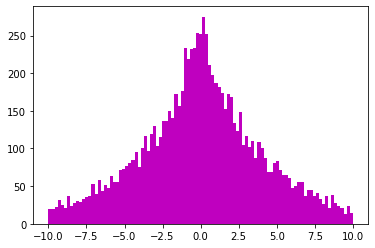

In [35]:
noiseNums = []
for i in range(10000):
    noiseNum = laplaceMechanism(x, epsilon, sensitivity)
    noiseNums.append(noiseNum)
    
binBoundaries = np.linspace(-10,10,100)
plt.hist(np.asarray(noiseNums, dtype='float'), bins=binBoundaries, color = 'm')
plt.show()

Observe that after 10,000 runs the noisy number outputted from the Laplace mechanism reflects the same shape as the theoretical Laplace function.  If you overlay the theoretical probability density function on the sampled output fro 10,000 runs, you can see that the output looks a lot like the function itself.

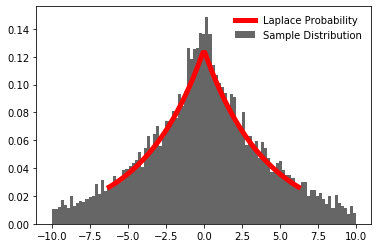

In [36]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(laplace.ppf(0.001), laplace.ppf(0.999), 100)
#ax.plot(x, laplace.pdf(x),'r-', lw=5, alpha= .5, label='laplace pdf')
rv = laplace(0, 2*sensitivity/epsilon)
ax.plot(x, rv.pdf(x), 'r-', lw=5, label='Laplace Probability ')
r = noiseNums
ax.hist(r, density=True, histtype='stepfilled', alpha=0.6, bins = binBoundaries, label= "Sample Distribution", color = 'k')
ax.legend(loc='best', frameon=False)
plt.show()

### 2.3 What can sampled confidence intervals tell us?

*For those who are statistically curious here is a deeper dive into the behavior of the Laplace Mechanism.  For those less interested, skip to the next section.*

What can we observe here in terms of practical implications for database queries using Laplacian Mechanisms?

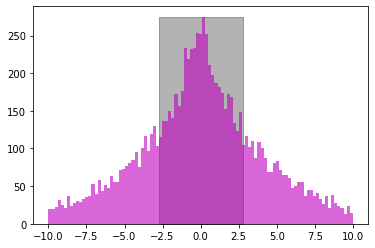

In [37]:
#Calculate percentiles for samples, 50% of the sampled distribution
a = np.array(noiseNums)
p1 = np.percentile(a, 75) 
p2 = np.percentile(a, 25)
height, bins, patches = plt.hist(noiseNums, alpha=0.6, bins = binBoundaries, color = 'm')
plt.fill_betweenx([0, height.max()], p1, p2, color='k', alpha=0.3)

In [40]:
md("Notice with these parameters settings, 50% of the observations fall outisde of the \
   interval {} and {}!".format(round(p2,2),round(p1,2)))

Notice with these parameters settings, 50% of the observations fall outisde of the    interval -2.71 and 2.76!

This histogram and the calculations tell us that 50% of the time in our runs the value returned was 2.7 larger or smaller than the true value. That level of randomness in our output go along way towards disguising the actual true value.

Now try the experiment with lower privacy, set $\epsilon$ = 4 and $\delta$ = 1

-0.3455741044920781 0.3469673344803448


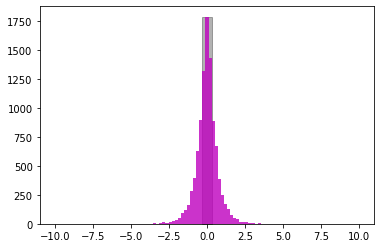

In [26]:
# Choose parameters with very high epsilon (lots of privacy leakage)
x = 0
epsilon = 4
sensitivity = 1
noiseNums = []
for i in range(10000):
    noiseNum = laplaceMechanism(x, epsilon, sensitivity)
    noiseNums.append(noiseNum)
#Calculate percentiles for samples, 50%
a = np.array(noiseNums)
p1 = np.percentile(a, 75) 
p2 = np.percentile(a, 25)
print(p2, p1) 
binBoundaries = np.linspace(-10,10,100)
ci = norm(*norm.fit(noiseNums)).interval(0.50)  
height, bins, patches = plt.hist(noiseNums, alpha=0.8, bins = binBoundaries, color = 'm')
plt.fill_betweenx([0, height.max()], p2, p1, color='k', alpha=0.3) 

**Big difference! Look at the histogram more illustrative bin boundaries.**

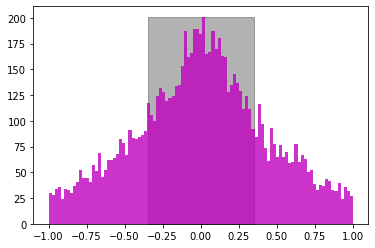

In [27]:
binBoundaries = np.linspace(-1,1,100)
ci = norm(*norm.fit(noiseNums)).interval(0.50)  
height, bins, patches = plt.hist(noiseNums, alpha=0.8, bins = binBoundaries, color = 'm')
plt.fill_betweenx([0, height.max()], p2, p1, color='k', alpha=0.3) 

In [28]:
md("Notice with these pa rameters settings, 50% of the observations fall outisde of the \
   interval {} and {}!".format(p2,p1))

Notice with these pa rameters settings, 50% of the observations fall outisde of the    interval -0.3455741044920781 and 0.3469673344803448!

The histogram and calculation show us that 50% of the time the value returned from a query will be within .34 of the true value!

What does this exercise show us?

With an $\epsilon$ = .5 it will be very hard to to have any confidence about the true value of our number, with $\epsilon$ = 4 it will gain a lot more confidence about the true value of our number with our database queries.

### 3. Explore Our Balding Bears Database and DP Laplace Mechanism COUNT

Recall our example where we are studying the impact of dietary habits of the brown bear and the potential implications of diet on the loss of fur of our salmon eating friends. 

Specifically, our example database contains a list of bears, all of whom are losing their fur.  They are balding.  No self-respecting bear wants such a sensitive fact made public. Disclosure of a bear's membership in this database means breaching the privacy of the bear's senstive attribute: they are going bald.

Consider the facts around the balding bears database.

- When the salmon are running large, talented and strong brown bears can catch in excess of 30 salmon per day
- Lesser talented, "normal" bears tend to collect and eat 10 - 20 salmon per day
- There may be bears with unique salmon catching talent in the range for 50+ salmon per day
- Our differential privacy mechanisms need to protect them all!

![Oski](./images/oski.png)

Let's first explore a queries to **count** the number of bears in the database. An differentially private **count** aggregation query is the simplest to explore.  So let's take a look!

Recall the eating habits of our bears on July 30th, including our salmon catching star Oski, who ate a whopping 48 salmon that day.

[10, 13, 14, 12, 18, 14, 18, 17, 16, 12, 48]



In [58]:
def ANON_COUNT(col, epsilon, sensitivity):
    trueCount = np.shape(col)[0]
    noisyCount = laplaceMechanism(trueCount, epsilon, sensitivity)
    return noisyCount

For simplicity we create a pandas dataframe of all of our balding bears.

In [43]:
#Create a dataframe of the balding bears
baldingBears = pd.DataFrame({'Bears': ['Avalanche', 'Bananas', 'Benny', 'Boomer', 'Grizz', 'Kody', 'Monte', 'Nanook', 'Ranger', 'Scott Highlander', 
                                       'Oski'],'School': ['Kutztown', 'U of Maine', 'Morgan State', 'Lake Forest', 'Oakland', 'Cascadia', 'U Montana', 
                                       'Bowdoin', 'Drew', 'UC Riverside','Berkeley'], 'Salmon':[10, 13, 14, 12, 18, 14, 18, 17, 16, 12, 48]})


In [44]:
# add 1 to each index
baldingBears.index = baldingBears.index + 1

In [45]:
baldingBears

,Bears,School,Salmon
1,Avalanche,Kutztown,10
2,Bananas,U of Maine,13
3,Benny,Morgan State,14
4,Boomer,Lake Forest,12
5,Grizz,Oakland,18
6,Kody,Cascadia,14
7,Monte,U Montana,18
8,Nanook,Bowdoin,17
9,Ranger,Drew,16
10,Scott Highlander,UC Riverside,12


With Oski in the database we have 11 members, our "trueCount".  Let's follow the same path of exploration and first choose privacy parameters that are considered to have very low privacy leakage, namely a low $\epsilon$ value = $.5$.  Here we can set the sensitivity parameter $\Delta$ = $1$ because the counts or two different databases that differ by only one record will differ by only one count.  Note this is an "unbounded" sensitivity.  A "bounded" sensitivity would be $2$ The difference relates to how we define difference, but for the purposes of this discussion we will choose $\Delta = 1$.

In [126]:
# Choose parameters with very low epsilon (little privacy leakage)
trueCount = 11
epsilon = .5
sensitivity = 1
col = baldingBears['Salmon']

Repeatedly execute the following cell to observe the output of the differentially private **count** query that employs our Laplacian Mechanism with these parameters.

In [127]:
noisyCount = ANON_COUNT(col, epsilon, sensitivity)
print(noisyCount)                   

15.781905477326859


Now run the **count** query $10,000$ times on the badling bears database and observe the results.

In [128]:
noisyCounts = []
for i in range(10000):
    noisyCount = ANON_COUNT(col, epsilon, sensitivity)  
    noisyCounts.append(noisyCount)

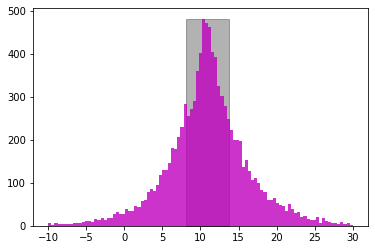

In [129]:
#Calculate percentiles for samples, 50%
a = np.array(noisyCounts)
p1 = np.percentile(a, 75) 
p2 = np.percentile(a, 25)
binBoundaries = np.linspace(-10,30,100)  
height, bins, patches = plt.hist(noisyCounts, alpha=0.8, bins = binBoundaries, color = 'm')
plt.fill_betweenx([0, height.max()], p2, p1, color='k', alpha=0.3) 

In [137]:
md("Notice with these pa rameters settings, 50% of the observations fall outisde of the \
   interval {} and {}!".format(p2,p1))

Notice with these pa rameters settings, 50% of the observations fall outisde of the    interval 8.061398252164583 and 13.795550926256457!

In [138]:
# Choose parameters with very high epsilon (subsstanital privacy leakage)
epsilon = 5

In [139]:
noisyCounts = []
for i in range(10000):
    noisyCount = ANON_COUNT(col, epsilon, sensitivity)  
    noisyCounts.append(noisyCount)

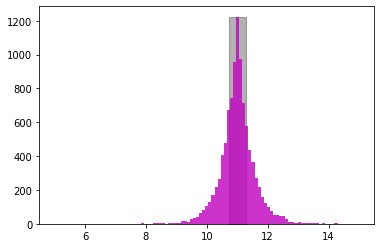

In [142]:
a = np.array(noisyCounts)
p1 = np.percentile(a, 75) 
p2 = np.percentile(a, 25)
binBoundaries = np.linspace(5,15,100) 
height, bins, patches = plt.hist(noisyCounts, alpha=0.8, bins = binBoundaries, color = 'm')
plt.fill_betweenx([0, height.max()], p2, p1, color='k', alpha=0.3) 

In [143]:
md("Notice with these parameter settings, 50% of the observations fall inside of the \
   interval {} and {}!".format(p2,p1))

Notice with these parameter settings, 50% of the observations fall inside of the    interval 10.718006190070863 and 11.280617700983527!

Notice with the lower privacy gaurantees that our samples suggest that there is a 50% chance that the count returned by the differential privacy mechanism will fall within .5 of the true count or be within approximately 5% of the true count!  Play with the parameters and re-run the previous 4 cells.

### 4. Explore Our Balding Bears Database, DP Laplace Mechanism SUM and Sensitivity $\Delta$ 

Next we explore the aggregation query **sum**.  Suppose we want to know the total number of salmon eaten on July 30th, by all of our bears combined.  But we want to protect the privacy of every bear in the database and **potential new members, outliers (also referred to as underepresented populations)**.

First consider the database of bears without Oski.  Suppose we query the total of all salmon eaten by our bears. Without Oski in the database the sum is $144$. 

Set the parameter $\epsilon$ at 1, a fairly private setting for most use cases.   

In [56]:
def ANON_SUM(col, epsilon, sensitivity):
    trueSum = np.sum(col)
    noisySum = laplaceMechanism(trueSum, epsilon,sensitivity)
    return noisySum

In [47]:
#Create a dataframe of the balding bears without Oski
baldingBears_no_Oski = pd.DataFrame({'Bears': ['Avalanche', 'Bananas', 'Benny', 'Boomer', 'Grizz', 'Kody', 'Monte', 'Nanook', 'Ranger', 'Scott Highlander'],
                                    'School': ['Kutztown', 'U of Maine', 'Morgan State', 'Lake Forest', 'Oakland', 'Cascadia', 'U Montana', 
                                       'Bowdoin', 'Drew', 'UC Riverside'], 
                                    'Salmon':[10, 13, 14, 12, 18, 14, 18, 17, 16, 12]})


In [49]:
# add 1 to each index
baldingBears_no_Oski.index = baldingBears_no_Oski.index + 1

In [50]:
baldingBears_no_Oski

,Bears,School,Salmon
1,Avalanche,Kutztown,10
2,Bananas,U of Maine,13
3,Benny,Morgan State,14
4,Boomer,Lake Forest,12
5,Grizz,Oakland,18
6,Kody,Cascadia,14
7,Monte,U Montana,18
8,Nanook,Bowdoin,17
9,Ranger,Drew,16
10,Scott Highlander,UC Riverside,12


In [199]:
# Set Differential Privacy Parameters for Anonymous Sum
epsilon = 1
col = baldingBears_no_Oski['Salmon']
u = max(col)
l = min(col)
sensitivity = abs(u-l)

Repeatedly execute the following cell to observe the output of the differentially private **sum** query that employs our Laplacian Mechanism with these parameters.

In [200]:
ANON_SUM(col, epsilon, sensitivity)

165.0697598916203

Once again, let's run the **sum** query $10,000$ times.

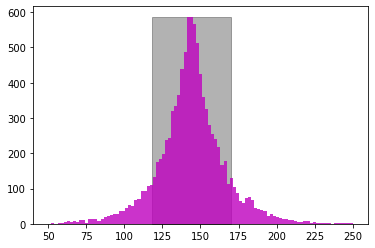

In [205]:
noisySums = []
col = baldingBears_no_Oski['Salmon']
for i in range(10000):
    noisySum = ANON_SUM(col, epsilon, sensitivity)  
    noisySums.append(noisySum)
a = np.array(noisySums)
p1 = np.percentile(a, 90) 
p2 = np.percentile(a, 10)
binBoundaries = np.linspace(50,250,100)
height, bins, patches = plt.hist(noisySums, alpha=0.8, bins = binBoundaries, color = 'm')
plt.fill_betweenx([0, height.max()], p1, p2, color='k', alpha=0.3)

In [207]:
md("Notice with these parameter settings, 90% of the observations fall inside of the \
   interval {} and {}!".format(round(p2,2),round(p1,2)))

Notice with these parameter settings, 90% of the observations fall inside of the    interval 118.42 and 169.93!

With a true sum of $144$, with $\epsilon = 1$  we can see that 50% of the time the output falls within 8% of the true sum.  Depending on the mindset of the attacker, this could be enough protection for this homegeneous group or it may fall short.  If we add another bear that is a modest eater anywhere in the range of 10-18 it is going to hard to try to learn anything new about that additional bear's identity.

But what happens if we introduce a bear, like Oski into the database.  We have prior knowledge that Oski is a big eater and through count queries we can notice a new member to the database.

**If we add Oski under these same parameters and run the sum query will we gain more information about whether or not Oski is the new member to the database?**

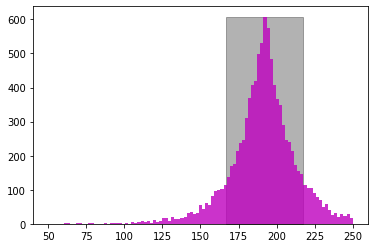

In [210]:
# Query the database for sum with Oski in the database
col = baldingBears['Salmon']
noisySums = []
for i in range(10000):
    noisySum = ANON_SUM(col, epsilon,sensitivity)  
    noisySums.append(noisySum)
a = np.array(noisySums)
p1 = np.percentile(a, 90) 
p2 = np.percentile(a, 10)   
binBoundaries = np.linspace(50,250,100)
height, bins, patches = plt.hist(noisySums, alpha=0.8, bins = binBoundaries, color = 'm')
plt.fill_betweenx([0, height.max()], p1, p2, color='k', alpha=0.3)

In [211]:
md("Notice with these parameter settings, 90% of the observations fall inside of the \
   interval {} and {}!".format(round(p2,2),round(p1,2)))

Notice with these parameter settings, 90% of the observations fall inside of the    interval 166.64 and 217.59!

**What can we see from these results?**

- If an attacker queries the database for sum many times before Oski is added to the database, then queries the database many times after he is included, 90% of the results will not overlap at all.  

- Recall at 90% the sample confidence interval without Oski was (approximately):
[118, 170]

- Recall at 90% the sample confidence interval with Oski was (approximately):
[166,217]

- With enough querying an attacker is going to be able to convince himself that a large, salmon devouring bear has been added, most likely our famous Oski.

- Oski's privacy, his balding fur, is at risk here.  Even with $\epsilon$ = 1.

**What can be done to make this aggregation query, sum, more differentially private?**

Notice we set the "sensitivity" of the query as the difference between the maximum and minimum value in the database without Oski in it.  THe sensitivity was set based on a reasonably homogenous population of bears.  So when we introduced an outlier, Oski, the sensitivity parameter was not set high enough to protect him.

**Set the sensitivity to protect an outlier!**

The sensitivity of a sum query is the maximum difference between the output of the query with or without any record in the database.  But in most practical use cases this difference must be estimated, guessed based on practical knowledge of a situation. In the case of our bears, to set the sensitivity to protect Oski or any voracious bear, we estimate that the maximum number of salmon any bear could catch and eat in a day is 50 salmon (just a guess).  Further a bear may begin to starve if it eats fewere than 10 salmon.  Thus, the difference between the sum with any new bear added to a database is no more than 50 and no less than 10.  Thus the sensitivity of the sum query in this situation is 40 fish, or 40.  

**Re-run the sum query with sensitivity = $40$.**

Simply using the minimum and the maximum of the database without Oski set senstivity to 8 fish. Very different results are seen if we set the senstivity at our "user-defined" maximums and minimums.


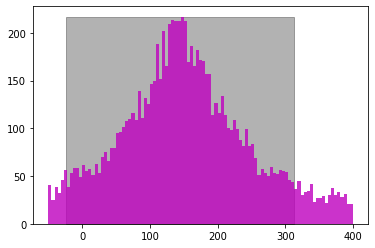

In [215]:
epsilon = 1
u = 60
l = 8
sensitivity = abs(u-l)
col = baldingBears_no_Oski['Salmon']

noisySums = []
for i in range(10000):
    noisySum = ANON_SUM(col, epsilon, sensitivity)  
    noisySums.append(noisySum)
    
a = np.array(noisySums)
p1 = np.percentile(a, 90) 
p2 = np.percentile(a, 10)  
binBoundaries = np.linspace(-50,400,100)  
height, bins, patches = plt.hist(noisySums, alpha=0.8, bins = binBoundaries, color = 'm')
plt.fill_betweenx([0, height.max()], p2, p1, color='k', alpha=0.3) 

In [219]:
md("Notice with these parameter settings, 90% of the observations fall inside of the \
   interval {} and {}!".format(round(p2,2),round(p1,2)))

Notice with these parameter settings, 90% of the observations fall inside of the    interval 29.8 and 357.27!

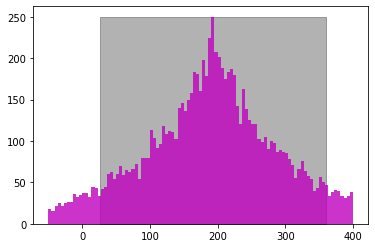

In [220]:
epsilon = 1
u = 60
l = 8
sensitivity = abs(u-l)
col = baldingBears['Salmon']

noisySums = []
for i in range(10000):
    noisySum = ANON_SUM(col, epsilon, sensitivity)  
    noisySums.append(noisySum)
    
a = np.array(noisySums)
p1 = np.percentile(a, 90) 
p2 = np.percentile(a, 10)  
binBoundaries = np.linspace(-50,400,100)  
height, bins, patches = plt.hist(noisySums, alpha=0.8, bins = binBoundaries, color = 'm')
plt.fill_betweenx([0, height.max()], p2, p1, color='k', alpha=0.3) 

In [221]:
md("Notice with these parameter settings, 90% of the observations fall inside of the \
   interval {} and {}!".format(round(p2,2),round(p1,2)))

Notice with these parameter settings, 90% of the observations fall inside of the    interval 25.86 and 360.03!

**What did we learn from this?**

- If an attacker queries the database for sum many times before Oski is added to the database, then queries the database many times after he is included, 90% of the results will not overlap at all.  

- Recall at 90% the sample confidence interval without Oski was (approximately):
[30, 358]

- Recall at 90% the sample confidence interval with Oski was (approximately):
[26, 360]

- With very high probability, an attacker is not going to be able discern that Oski has been added to the database

- Here the Laplace Mechanism uses the sensitivity parameter to protect Oski's membership in the database!

- But there is a significant loss of utility!

- Low $\epsilon$ and high $\Delta$ are protecting outliers to a very large degree, but rendering the results far less useful!

- To create the right balance of privacy and utility, increase $\epsilon$ and/or decrease the $\Delta$ until the acceptable levels of privacy and utility for a particular use case. 

### 5. Exploring the Average Query!

The results for adjusting parameters to make queries that ask for the average or median of a dataset very similar.  In this section we present code to allow you to experiment in this section.  The primary difference between **sum** and **average** differentially private queries is in setting the senstivity parameter.  For **sum** there is a higher potential for information leakage so the sensitivity parameter needs to be greater if it is to protect outliers such as Oski.  Check it out!

In [52]:
def ANON_AVG_SIMPLE(col, epsilon, sensitivity):
    noisySum = ANON_SUM(col, epsilon, sensitivity)
    noisyCount = ANON_COUNT(col, epsilon, 1)
    return noisySum/noisyCount

In [53]:
def ANON_AVG_CLAMPING(col, epsilon, u, l):
    trueSum = np.sum(col) 
    trueCount = np.shape(col)[0] 
    sensitivity = u-l
    a = laplaceMechanism(trueSum, epsilon, sensitivity)/trueCount
    if a <= l:
        return l
    else:
        if a >= u:
            return u
        else: 
            return a

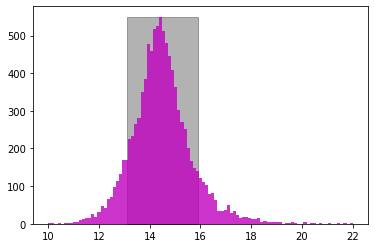

In [239]:
# Low epsilon, low sensitivity, no Oski
epsilon = 4
u = 18
l = 10
sensitivity = abs(u-l)
col = baldingBears_no_Oski['Salmon']

noisyAvgs = []
for i in range(10000):
    noisyAvg = ANON_AVG_SIMPLE(col, epsilon, sensitivity)
    noisyAvgs.append(noisyAvg)

a = np.array(noisyAvgs)
p1 = np.percentile(a, 90) 
p2 = np.percentile(a, 10)     
binBoundaries = np.linspace(10,22,100)
height, bins, patches = plt.hist(noisyAvgs, alpha=0.8, bins = binBoundaries, color = 'm')
plt.fill_betweenx([0, height.max()], p2, p1, color='k', alpha=0.3) 

In [240]:
md("Notice with these parameter settings, 90% of the observations fall inside of the \
   interval {} and {}!".format(round(p2,2),round(p1,2)))

Notice with these parameter settings, 90% of the observations fall inside of the    interval 13.11 and 15.92!

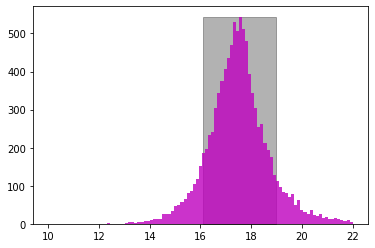

In [241]:
# High epsilon, low sensitivity, Oski
epsilon = 4
u = 18
l = 10
sensitivity = abs(u-l)
col = baldingBears['Salmon']

noisyAvgs = []
for i in range(10000):
    noisyAvg = ANON_AVG_SIMPLE(col, epsilon, sensitivity)
    noisyAvgs.append(noisyAvg)

a = np.array(noisyAvgs)
p1 = np.percentile(a, 90) 
p2 = np.percentile(a, 10)     
binBoundaries = np.linspace(10,22,100)
height, bins, patches = plt.hist(noisyAvgs, alpha=0.8, bins = binBoundaries, color = 'm')
plt.fill_betweenx([0, height.max()], p2, p1, color='k', alpha=0.3)

In [243]:
md("Notice with these parameter settings, 90% of the observations fall inside of the \
   interval {} and {}!".format(round(p2,2),round(p1,2)))

Notice with these parameter settings, 90% of the observations fall inside of the    interval 16.08 and 18.98!

**What did we learn from this?**

- If an attacker queries the database for **average** many times before Oski is added to the database, then queries the database many times after he is included, 90% of the results will not overlap at all!! 

- Recall at 90% the sample confidence interval without Oski was (approximately):
[13, 16]

- Recall at 90% the sample confidence interval with Oski was (approximately):
[16, 19]

- With very high probability, an attacker is not going to be able discern that Oski has been added to the database, using the average query

- Clearly, less privacy leakage, lower $\epsilon$ is required


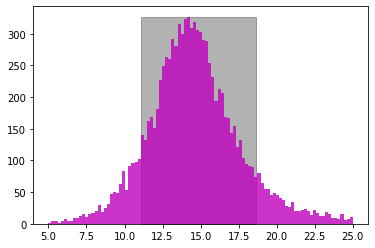

In [72]:
# Lower epsilon, higher sensitivity, no Oski
epsilon = 1.9
u = 25
l = 10
sensitivity = abs(u-l)
col = baldingBears_no_Oski['Salmon']

noisyAvgs = []
for i in range(10000):
    noisyAvg = ANON_AVG_SIMPLE(col, epsilon, sensitivity)
    noisyAvgs.append(noisyAvg)

a = np.array(noisyAvgs)
p1 = np.percentile(a, 90) 
p2 = np.percentile(a, 10)     
binBoundaries = np.linspace(5,25,100)
height, bins, patches = plt.hist(noisyAvgs, alpha=0.8, bins = binBoundaries, color = 'm')
plt.fill_betweenx([0, height.max()], p2, p1, color='k', alpha=0.3)


In [73]:
md("Notice with these parameter settings, 90% of the observations fall inside of the \
   interval {} and {}!".format(round(p2,2),round(p1,2)))

Notice with these parameter settings, 90% of the observations fall inside of the    interval 11.07 and 18.67!

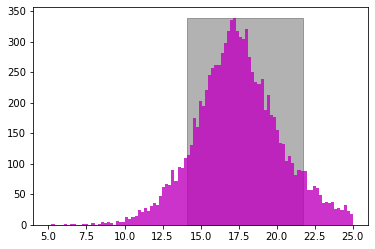

In [74]:
# Lower epsilon, higher sensitivity, Oski
col = baldingBears['Salmon']
noisyAvgs = []
for i in range(10000):
    noisyAvg = ANON_AVG_SIMPLE(col, epsilon, sensitivity)
    noisyAvgs.append(noisyAvg)

a = np.array(noisyAvgs)
p1 = np.percentile(a, 90) 
p2 = np.percentile(a, 10)     
binBoundaries = np.linspace(5,25,100)
height, bins, patches = plt.hist(noisyAvgs, alpha=0.8, bins = binBoundaries, color = 'm')
plt.fill_betweenx([0, height.max()], p2, p1, color='k', alpha=0.3)

In [75]:
md("Notice with these parameter settings, 90% of the observations fall inside of the \
   interval {} and {}!".format(round(p2,2),round(p1,2)))

Notice with these parameter settings, 90% of the observations fall inside of the    interval 14.11 and 21.73!

**What did we learn from this?**

- $\epsilon$ in the range of 1.5 to 2.0, sensitivity $\Delta$ in the range of 10 to 15 still provides privacy with better utility

- Tinker with the parameters yourself and look at the results.

- Do you think $\epsilon = 1$ is too much privacy and too little utility?

- What do you think are the optimial parameters here?

### 6. Conclusions

Congratulations for wending your way through some of the aspects of a Laplacian Differential Privacy Mechanism! We hope you have gained some insight into how this mechanism works and you are now inspired to learn more!

When you find yourself confused, struggling to remember, think back to Oski and his cohort of balding brown bear friends.

Some key take aways include the following.

- Laplacian mechanisms inject privacy crafted noise into query responses

- This crafted noise protects members of a database from an increase in confidence that any given individual will be identifid as a member in the database

- The Laplacian mechanism requires fine tuning of $\epsilon$ for **count** and both $\epsilon$ and $\Delta$ for **sum** and **average** to manage the privacy - utility trade-off for specific use cases.

- The sensitivity parameter should be set to protect **potential** members values, not just **existing** member values!

- The sensitivity parameter should be set to protect potential outliers, or underrepresented populations, those that may deviate from the more homogenous population that tends to be close to the "norm". 

- Differentail Privacy is very cool!